In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r
import scipy.io as sio
import math

%matplotlib inline

## SVM methods

In [2]:
def calculate_kernel(X):
    """
    Calculates the kernel using the formula
    X * X.T
    
    Parameters
    ----------
    X : N x d matrix
    
    Returns
    -------
    N x N matrix
    """
    return X * X.T

def predict(Ki, Y, A, b):
    """
    Calculates the prediction for all inputs
    using the formula: 
    f(x) = sum(A[i] * Y[i] * K(X[i], X)){i=1..N} + b
    where K is the kernel function.
    
    Parameters
    ----------
    Ki: 1 x N matrix
        Contains the dot product between X[i] and X
    Y : N x 1 matrix
        Contains the true classes for input data
    A : N x 1 matrix 
        Contains the lagrange multipliers
    b : Double
        The intercept term
    
    Returns
    -------
    Double
        Calculated hypothesis
    """
    # Calculate Y[i] * K(X[i], X) for all i in
    # 1 to N. Returns N x 1 matrix.
    inner = np.multiply(Y, Ki.T)
    
    # Calculate A[i] * { Y[i] * K(X[i], X) } for
    # all i in 1 to N. Returns N x 1 matrix.
    outer = np.multiply(A, inner)
    
    return np.sum(outer) + b

def get_bounds(Ai, Aj, Yi, Yj, C):
    """
    Specifies the lower and upper bounds based
    on Yi and Yj
    
    Parameters
    ----------
    Ai: Double
        Alpha value for first sample
    Aj: Double
        Alpha value for second sample
    Yi: Integer
        True class of first sample
    Yj: Integer
        True class of second sample
    C : Regularization parameter
    
    Returns
    -------
    Double, Double
        The lower and upper bounds
    """
    L = 0  # Lower bound
    H = 0  # Upper bound
    
    # Initialize the bounds
    if (Yi == Yj):
        L = max(0, Ai + Aj - C)
        H = min(C, Ai + Aj)
    else:
        L = max(0, Aj - Ai)
        H = min(C, C + Aj - Ai)
    
    return L, H

def calculate_eta(Xi, Xj):
    """
    Calculates the value of Eta using the
    formula: 2 * Xi * Xj.T - Xi * Xi.T -
    Xj * Xj.T
    
    Parameters
    ----------
    Xi: 1 x d matrix
        Contains one input sample
    Xj: 1 x d matrix
        Contains another input sample
    
    Returns
    -------
    Double
        The calculated value of Eta
    """
    
    first = 2 * Xi * Xj.T
    second = Xi * Xi.T
    third = Xj * Xj.T
    
    eta = first - second - third
    
    return eta.getA1()[0]

def compute_and_clip_alpha(Aj, Yj, Ei, Ej, eta, L, H):
    """
    Computes the new value for Aj using the
    formula: Aj = Aj - Yj * (Ei - Ej) / eta.
    Then the value of Aj is clipped to lie
    within the range [L, H].
    
    Parameters
    ----------
    Aj: Double
        Alpha value of second sample
    Yj: Integer
        True class of the second sample
    Ei: Double
        Prediction error in the first sample
    Ej: Double
        Prediction error in the second sample
    eta:Double
        The value of Eta
    L : Double
        The lower bound
    H : Double
        The upper bound
    
    Returns
    -------
    Double
        The new value for Aj
    """
    
    # Compute new Aj
    Aj = Aj - (Yj * (Ei - Ej)) / eta
    
    # Clip Aj to [L, H]
    if (Aj > H):
        Aj = H
    elif (Aj < L):
        Aj = L
    
    return Aj

def update_first_alpha(Ai, Aj, Aj_old, Yi, Yj):
    """
    Computes the new alpha value for first
    sample using the formula: Ai + Yi * Yj *
    (Aj_old - Aj)
    
    Parameters
    ----------
    Ai: Double
        Alpha value for first sample
    Aj: Double
        Alpha value for second sample
    Aj_old: Double
        The old alpha value for second sample
    Yi: Integer
        True class of first sample
    Yj: Integer
        True class of second sample
    
    Returns
    -------
    Double
        The new alpha value for first sample
    """    
    inner = Yi * Yj * (Aj_old - Aj)
    return Ai + inner

def compute_threshold(Xi, Xj, Yi, Yj, Ai, Aj, Ai_old, Aj_old, Ei, Ej, b, C):
    """
    Calculates the new value for b threshold
    
    Parameters
    ----------
    Xi: 1 x d matrix
        Contains one input sample
    Xj: 1 x d matrix
        Contains another input sample
    Yi: Integer
        True class of first sample
    Yj: Integer
        True class of second sample
    Ai: Double
        Alpha value for first sample
    Aj: Double
        Alpha value for second sample
    Ai_old: Double
        The old alpha value for first sample
    Aj_old: Double
        The old alpha value for second sample
    Ei: Double
        Prediction error in the first sample
    Ej: Double
        Prediction error in the second sample
    b : Double
        Current value of the threshold
    C : Double
        The regularization parameter
    """
    inputs_dot_product = Xi * Xj.T
    inputs_dot_product = inputs_dot_product.getA1()[0]
    
    # Calculate b1
    xi_inner = Xi * Xi.T
    xi_inner = xi_inner.getA1()[0]
    first = Yi * (Ai - Ai_old) * xi_inner
    second = Yj * (Aj - Aj_old) * inputs_dot_product
    b1 = b - Ei - first - second
    
    # Calculate b2
    xj_inner = Xj * Xj.T
    xj_inner = xj_inner.getA1()[0]
    first = Yi * (Ai - Ai_old) * inputs_dot_product
    second = Yj * (Aj - Aj_old) * xj_inner
    b2 = b - Ej - first - second
    
    # Calculate the new value for b
    if ((0 < Ai) and (Ai < C)):
        b = b1
    elif ((0 < Aj) and (Aj < C)):
        b = b2
    else:
        b = (b1 + b2) / 2
    
    return b

def simplified_smo(X, Y, C, tol, max_passes):
    """
    Executes the simplified SMO algorithm to
    calculate the lagrange multipliers and the
    threshold for the solution
    
    Parameters
    ----------
    X : N x d matrix
        The input data
    Y : N x 1 matrix
        The true values for all inputs
    C : Double
        The regularization parameter
    tol:Double
        The numerical tolerance
    max_passes : Integer
        The maximum number of times to iterate
        over alpha's without changing
    
    Returns
    -------
    A : N x 1 matrix
        The lagrange multipliers
    b : Double
        The threshold
    """
    
    N = X.shape[0]  # Number of input samples
    d = X.shape[1]  # Number of features
    
    K = X * X.T  # The kernel
    
    # Initialize lagrange multipliers and the
    # b threshold
    A = np.matrix(np.zeros(N)).T  # N x 1
    b = 0
    
    passes = 0
    while (passes < max_passes):
        
        # Initialize variable to keep track of
        # the number of alphas that are updated
        # in this iteration
        num_changed_alphas = 0
        
        for i in range(N):
            
            # Extract kernel and true class
            # of the i-th input sample
            Ki = K[i, :]
            Xi = X[i, :]
            Yi = Y[i, :].getA1()[0]
            
            # Calculate prediction error for
            # first sample
            Pi = predict(Ki, Y, A, b)
            Ei = Pi - Yi
            
            Ai = A[i, :].getA1()[0]
            
            if ((Yi * Ei < -tol and Ai < C) or
                (Yi * Ei > tol and Ai > 0)):
                
                #print("Inside if")
                
                # Select j at random such that j != i
                while True:
                    j = np.random.randint(0, N)
                    if (j != i):
                        break
                
                # Extract kernel and true class
                # of the i-th input sample
                Kj = K[j, :]
                Xj = X[j, :]
                Yj = Y[j, :].getA1()[0]

                # Calculate prediction error for
                # first sample
                Pj = predict(Kj, Y, A, b)
                Ej = Pj - Yj
                
                Aj = A[j, :].getA1()[0]
                
                # Save Ai and Aj
                Ai_old = Ai
                Aj_old = Aj
                
                # Compute bounds
                L, H = get_bounds(Ai, Aj, Yi, Yj, C)
                
                if (L == H):
                    #print("L = H. Continue to next i")
                    continue  # Process next i
                
                # Compute Eta
                eta = calculate_eta(Xi, Xj)
                
                if (eta >= 0):
                    #print("eta >= 0. Continue to next i")
                    continue  # Process next i
                
                # Convert A matrix to an array temporarily for updation
                A = A.getA1()
                
                # Compute new Aj
                Aj = compute_and_clip_alpha(Aj, Yj, Ei, Ej, eta, L, H)
                A[j] = Aj
                
                if (abs(Aj - Aj_old) < math.pow(10, -5)):
                    A = np.matrix(A).T
                    continue  # Process next i
                
                # Calculate new Ai
                Ai = update_first_alpha(Ai, Aj, Aj_old, Yi, Yj)
                A[i] = Ai
                
                # Convert A back to a N x 1 matrix
                A = np.matrix(A).T
                
                # Calculate new b threshold
                b = compute_threshold(Xi, Xj, Yi, Yj, Ai, Aj, Ai_old, Aj_old, Ei, Ej, b, C)
                
                num_changed_alphas += 1
                
            # end if
            
        # end for
        
        if (num_changed_alphas == 0):
            passes += 1
        else:
            passes = 0
            
    # end while
    
    return A, b

def classify(A, Y_trn, X_trn, X, b):
    """
    Predicts the classes for each input data point
    in X using the formula: A[i] * Y_trn[i] * 
    (X_trn[i] * X) + b. The prediction is 1 if 
    this calculate value is > 0. Else 0.
    
    Parameters
    ----------
    A : N_trn x 1 matrix
        The optimized Lagrangian multipliers
    Y_trn : N_trn x 1 matrix
        The true classes for training data
    X_trn : N_trn x d matrix
        The features for training data
    X : N x d matrix
        The features for data which needs to be
        classified
    b : Double
        The threshold
    
    Returns
    -------
    N x 1 matrix
        Containing the predicted classes for all
        input data points
    """
    
    K = X_trn * X.T  # The kernel - N_trn x N
    
    # Calculate Y_trn[i] * <X_trn[i], X> for all i
    inner = np.multiply(Y_trn, K)
    
    # Multiply lagrange multipliers and add the
    # threshold
    outer = np.multiply(A, inner)
    outer = np.matrix(np.sum(outer, axis = 0)).T
    outer = outer + b
    
    # Calculate the final prediction
    return vector_indicator(outer)

## Helper Functions

In [3]:
def load_data(path, x_col, y_col):
    """
    Reads the contents of a matlab file into
    a dataframe
    
    Parameters
    ----------
    path : String
        Relative path to the input data file
    x_col : String
        Header of the column storing features
    y_col : String
        Header of the column storing actual
        classes
    
    Returns
    -------
    Pandas DataFrame
        Contains the data read from the file
    """
    # Load the data
    data = sio.loadmat(path)
    
    # Convert to dataframe
    data = pd.DataFrame(
                np.hstack(
                    (data[x_col],
                     data[y_col])))
    
    # Define the column headers
    data.columns = ['x1', 'x2', y_col]
    
    # Return the data
    return data

def pre_process(data, y_col):
    """
    Split the input data into a matrix that
    contains all features and a matrix that
    contains all output classes
    
    Parameters
    ----------
    data : Pandas DataFrame
        Contains the input data
    y_col : String
        Header of the result column
    
    Returns
    -------
    N x d matrix
        Storing d features for N samples
    N x 1 matrix
        Storing the classification for N
        samples
    """    
    data_cols = list(data.columns.values)
    data_cols.remove(y_col)
    
    X = data[data_cols]
    X = np.matrix(X.values)
    
    Y = data[[y_col]]
    Y = vector_class_update(np.matrix(Y.values))
    
    return X, Y

def indicator(score):
    """
    Indicator function which returns 1
    if the score is > 0. Else, returns
    0.
    
    Parameters
    ----------
    score : Double        
    
    Returns
    -------
    Integer (either 0 or 1)
    """
    return 1 if (score > 0) else -1

vector_indicator = np.vectorize(indicator)

def class_update(true_class):
    """
    Updates the true classes 
    """
    return 1 if (true_class != 0) else -1

vector_class_update = np.vectorize(class_update)

def plot_data(data, y_col, y_pred):
    """
    Renders a scatter plot for the data
    passed in and colors the nodes based
    on their predicted classes.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Contains the input data along with
        their predicted classes
    y_col : String
        The name of the column storing true
        classes
    y_pred : String
        The name of the column storing the
        predicted classes
    """
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Draw the plots
    ax.scatter(data.x1, data.x2, label='Data', c=data[[y_pred]])
    
    # Set extra properties for readability
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('x1 vs. x2')
    
    # Set the x and y axis limits for the plot
    x1_min = data.x1.min()
    x1_max = data.x1.max()
    ax.set_xlim(x1_min + 0.2 * x1_min, x1_max + + 0.2 * x1_max)
    
    x2_min = data.x2.min()
    x2_max = data.x2.max()
    ax.set_ylim(x2_min + 0.2 * x2_min, x2_max + + 0.2 * x2_max)

def plot_misclassification_error(C, errors):
    plt.plot(C, errors, 'k-')
    plt.xlabel('C')
    plt.ylabel('Misclassifications')
    plt.xscale('log')
    #plt.yscale('log')

Misclassifications:  0


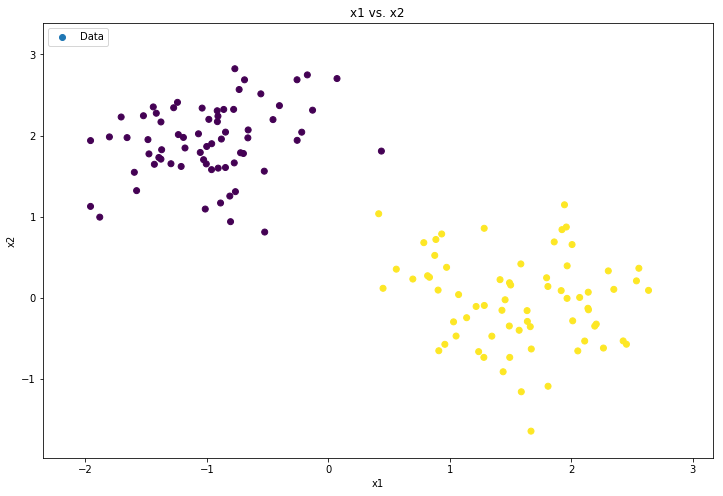

In [12]:
# --------------------------- Execution ------------------------------------

path = "data1.mat"
x_col = 'X_trn'
result_col_name = "Y_trn"

C = 1
tol = -1
max_passes = 10

train_data = load_data(path, x_col, result_col_name)
X_trn, Y_trn = pre_process(train_data, result_col_name)

A, b = simplified_smo(X_trn, Y_trn, C, tol, max_passes)
#print(A)

# ---------------------- Run the model on training data --------------------

prediction_col_name = 'Y_pred'

Y_pred = classify(A, Y_trn, X_trn, X_trn, b)

Y_trn_arr = Y_trn.getA1()
Y_pred_arr = Y_pred.getA1()

print("Misclassifications: ", np.sum(Y_trn_arr != Y_pred_arr))

# Convert the splits into dataframe
data_cols = list(['x1', 'x2'])
trn_data_df = pd.DataFrame(X_trn, columns=data_cols)
        
trn_data_df.insert(0, result_col_name, Y_trn)
trn_data_df.insert(0, prediction_col_name, Y_pred)

plot_data(trn_data_df, result_col_name, prediction_col_name)

Misclassifications:  0


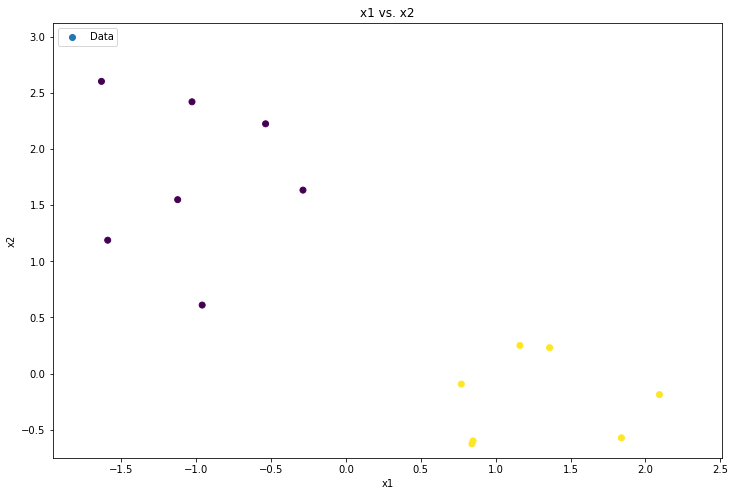

In [10]:
# ---------------------- Run the model on test data ------------------------

x_col = "X_tst"
result_col_name = "Y_tst"
prediction_col_name = 'Y_pred'

test_data = load_data(path, x_col, result_col_name)
X_tst, Y_tst = pre_process(test_data, result_col_name)

Y_pred = classify(A, Y_trn, X_trn, X_tst, b)

Y_tst_arr = Y_tst.getA1()
Y_pred_arr = Y_pred.getA1()

print("Misclassifications: ", np.sum(Y_tst_arr != Y_pred_arr))

# Convert the splits into dataframe
data_cols = list(['x1', 'x2'])
test_data_df = pd.DataFrame(X_tst, columns=data_cols)
        
test_data_df.insert(0, result_col_name, Y_tst)
test_data_df.insert(0, prediction_col_name, Y_pred)

plot_data(test_data_df, result_col_name, prediction_col_name)